# Neural Style Transfer
### John Guerrerio
## Neural Style Transfer Basic Explination

Neural style transfer is based on the idea of hierarchical learning in CNNs.  While earlier convolutional blocks learn surface level features like object boundaries, later convolutional blocks more abstract features.  We can use the representations of an image within the intermediate blocks of a pre-trained deep CNN to capture that image's content and structural features.  The feature maps from these later layers become the content representation of an image.  To extract an image's style representation, we use the Gram Matrix of the intermediate feature maps, which captures the correlations between different feature maps.  To compute the Gram matrix, we flatten each feature map and compute the outer product of these vectors.  The resulting matrix represents the correlations between different features in the feature maps.  Mathematically, we can consider the flattend feature maps as rows in a matrix F, and the Gram Matrix G as F multiplied by F.transpose.  

We use these content and style representations to define a new loss function.  We define the content loss as the mean squared error between the origional image's content feature maps and the generated image's content feature maps.  We define the style loss as the mean squared error between the style image's Gram Matrices and the generated image's Gram Matrices.  Our overall loss is given as the weighted sum of the style and content loss (the exact weights are a tunable hyperparameter).

Training for neural style transfer has significant differences from "normal" model training.  Instead of fixing the input images and updating the model weights, we fix the model weights and update the pixel values for the generated image.  This allows us to iteratively improve the generated image via backpropogating the style/content loss.

## Challenges
Neural style transfer has several challenges we must be aware of:
- Computational Resources: Neural style transfer involves optimization algorithms that require substantial computational resources, especially for high-resolution images. For the single example we present here, this is not a concern.  However, in real-word applications that generate multiple images, this is a factor to take into consideration.
- Loss of Content: Style transfer can introduce distortions or reduce content detail in the generated image, especially when the style image clashes with the content image.  For instance, a hyper-relaistic photo of a person as a content image might clash with an oil painting of a landscape as a style image.  
- Perception Consistency: The stylized image might not be consistent in terms of perceived style across different parts of the image.  This leads to visually unpleasing results.  Although this did not occur for this example, segmenting the image into regions and applying style transfer independently to each region can help the style to adapt to local content characteristics.

## Deployment

Neural style transfer can generate a wide variety of images and has a large degree of user customization.  To that end, I decided to deploy this algorithm using Gradio and a Huggingface space so end users can generate images of thier choice.



In [ ]:
!pip install gradio

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gradio as gr
import numpy as np

## Neural Style Transfer Example

Let's generate a landscape-painting style image of Baker tower as an example application of this algorithm.  This will also allow us to discuss different aspects of the algorithm.

In [ ]:
IMAGE_SIZE = 244 # VGG image input size - we use VGG 19 as our pretrained CNN

In [ ]:
EPOCHS = 2000
LEARNING_RATE = 0.001

# I tested several different weights for the overall loss function - these ones worked well
CONTENT_LOSS = 1 # weight for content loss in overall loss
STYLE_LOSS = 0.01 # weight for style loss in overall loss

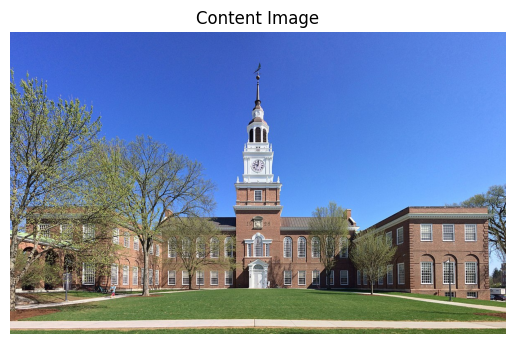

In [ ]:
img = mpimg.imread("BakerTower.jpg")
plt.imshow(img)
plt.axis('off')
plt.title('Content Image')
plt.show()

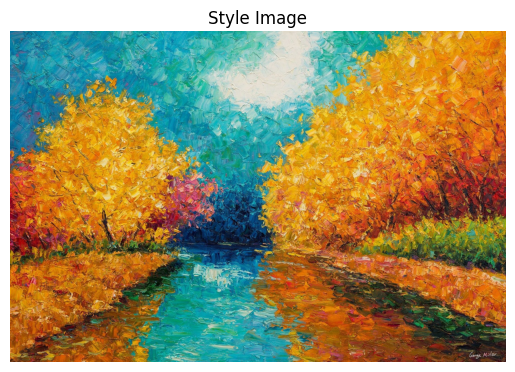

In [ ]:
img = mpimg.imread("Landscape.jpg")
plt.imshow(img)
plt.axis('off')
plt.title('Style Image')
plt.show()

The following transforms resize the images to 244x244 (which is important because the content image and the style image are different sizes) and convert them to torch tensors.  One potential way to improve generation quality would be to normalize the images using the same mean/standard deviation as the training for the pre-trained CNN we use.  This could be done through the following transform: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).  However, generation quality was high without this transform, so I chose not to include it in this case.

In [ ]:
notebook_transforms = transforms.Compose([
        transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),
        transforms.ToTensor(),
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


We have three different candidates as the seed for our generated image:
- Content Image: Using the content image helps preserve the content in the final generated image and may cause the optimization algorithm to more quickly converge to a a stylized image that closely resembles the content.  However, this choice could limit the influence of the style image and how much style is incorperated into the final generated image.
- Style Image: This choice reverses the pros and cons of the content image; the generated image will have strong characteristics of the style image, but might have content distortions or content loss.
- Random Noise:  Starting with random noise allows for more exploration of the style-space, potentially leading to more diverse and creative stylizations.  It also provides a neutral starting point that encourages a balanced integration of both content and style characteristics.  However, it may take longer to converge to an acceptably stylized output and the results are more unpredictable than the other two seed choices.

For this example, I found choosing the content image as the seed worked well.


In [ ]:
content = notebook_transforms(Image.open("BakerTower.jpg")).unsqueeze(0).to(device) # we unsqueeze to create a "batch size" of 1
style = notebook_transforms(Image.open("Landscape.jpg")).unsqueeze(0).to(device)
generated = content.clone().requires_grad_(True)

In [ ]:
# we use the vgg19 model as our pre-trained CNN
# we print the model here, as its architecture will help us determine which layers to
# extract image representations from for our neural style transfer
model = models.vgg19(weights="VGG19_Weights.DEFAULT").features
print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 75.7MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

The layers we choose to extract image representations from is an architectural choice subject to potential change.  We want to choose deeper layers to extract content features, as shallow layers extract more literal features like object boundaries.  We want to capture style features from multiple layers across the network.  This allows us to capture diverse features like texture, color, definition, etc.  We choose to use the first convolution layer and the convolution layer immediately after each max pool operation.  The advantages of this approach are as follows:
- Layers after max pooling have larger receptive fields, meaning each individual neuron captures more information from the input image.  This allows the feature maps to capture broader contextual information from the input image and consider global relationships between different parts of the image.  Ultimately, this creates more coherent stylizations.
- Max pooling operations reduce the spatial dimensions of the feature maps, which can help in capturing global patterns and stylistic elements of the image. This can lead to more robust style transfer, as the network focuses on capturing overall style characteristics rather than fine-grained details.
- Features extracted from layers after max pooling tend to be more stable and invariant to local variations in the input image.  This can help ensure consistency in the stylized output across different regions of the image.

In [ ]:
class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    self.layers = ['0', '5', '10', '19', '28'] # layers we use as representations
    self.model = models.vgg19(weights="VGG19_Weights.DEFAULT").features[:29] # we don't care about later layers

  def forward(self, x):
    features = []

    for layer_num, layer in enumerate(self.model):
      x = layer(x)

      # we don't care about the model output - we care about the output of individual layers
      if str(layer_num) in self.layers:
        features.append(x)

    return features

In [ ]:
model = VGG().to(device).eval()
optimizer = optim.Adam([generated], lr=LEARNING_RATE) # we train the input image, not the model

In [ ]:
# sanity check of image size
print(content.size())
print(style.size())
print(generated.size())

torch.Size([1, 3, 244, 244])
torch.Size([1, 3, 244, 244])
torch.Size([1, 3, 244, 244])


In [ ]:
for epoch in range(EPOCHS):
    # get feature maps for generated, content and style images
    generatedFeatures = model(generated)
    contentFeatures = model(content)
    styleFeatures = model(style)

    styleLoss = 0
    contentLoss = 0

    for genFeat, contFeat, styleFeat in zip(generatedFeatures, contentFeatures, styleFeatures):
      batch_size, channel, height, width = genFeat.shape

      # mean squared error between generated and content feature maps
      contentLoss += torch.mean((genFeat - contFeat) ** 2)

      # gram matrices for generated and style images
      G = genFeat.view(channel, height * width).mm(genFeat.view(channel, height * width).t())
      A = styleFeat.view(channel, height * width).mm(styleFeat.view(channel, height * width).t())

      # mean squared error gor gram matrices
      styleLoss += torch.mean((G - A) ** 2)

    total_loss = CONTENT_LOSS * contentLoss + STYLE_LOSS * styleLoss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
      print(f'EPOCH: {epoch} --- LOSS: {total_loss}')
      save_image(generated, "generated.png")

EPOCH: 0 --- LOSS: 139585.34375
EPOCH: 200 --- LOSS: 23954.822265625
EPOCH: 400 --- LOSS: 13293.998046875
EPOCH: 600 --- LOSS: 7941.3837890625
EPOCH: 800 --- LOSS: 4718.185546875
EPOCH: 1000 --- LOSS: 2718.22314453125
EPOCH: 1200 --- LOSS: 1522.990966796875
EPOCH: 1400 --- LOSS: 884.1083374023438
EPOCH: 1600 --- LOSS: 571.587646484375
EPOCH: 1800 --- LOSS: 416.94256591796875


This task is far more subjective than the classifier or the GAN, as the quality of the generated image and the acceptable level of style incorporated within the image are up to interpretaton.  However, I think the below image does a good job of capturing the oil painting style while maintaining the content of the origional image

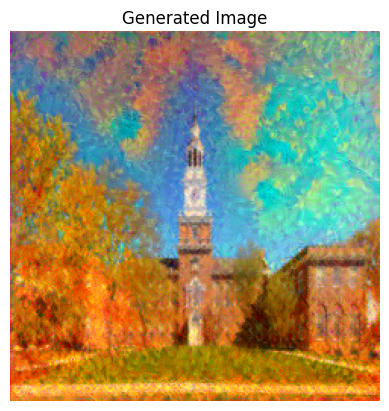

In [ ]:
img = mpimg.imread("generated.png")
plt.imshow(img)
plt.axis('off')
plt.title('Generated Image')
plt.show()

## Deployment
### Huggingface Space Link: https://huggingface.co/spaces/JohnG112358/StyleTransfer

The below cells define the Gradio interface I developed to deploy the model.  However, by including them here as well, the person running this notebook can take advantage of Colab's GPUs to speed up runtime.

In [ ]:
# functions for the gradio interface
gradio_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize([IMAGE_SIZE, IMAGE_SIZE])
])

# ensure hyper-parameters are valid
def sanitize_inputs(epochs, lr, cl, sl):
  if epochs < 1:
    return ["Epochs must be positive", None]
  if not isinstance(epochs, int):
    return ["Epochs must be an integer", None]
  if lr < 0:
    return ["Learning rate must be positive", None]
  if lr > 1:
    return ["Learning rate must be less than one", None]
  if cl < 0 or cl > 1:
    return ["Content loss weight must be between 0 and 1", None]
  if sl < 0 or sl > 1:
    return ["Style loss weight must be between 0 and 1", None]

  return None

# generate the new image
def train(Epochs, Learning_Rate, Content_Loss, Style_Loss, Content_Image, Style_Image):
  errors = sanitize_inputs(Epochs, Learning_Rate, Content_Loss, Style_Loss)
  if errors is not None:
    return errors

  test = Content_Image

  content = gradio_transforms(Content_Image).unsqueeze(0).to(device)
  style = gradio_transforms(Style_Image).unsqueeze(0).to(device)
  generated = content.clone().requires_grad_(True).to(device)

  model = VGG().to(device).eval()
  optimizer = optim.Adam([generated], lr=Learning_Rate)

  for epoch in range(Epochs):
    generatedFeatures = model(generated)
    contentFeatures = model(content)
    styleFeatures = model(style)

    styleLoss = 0
    contentLoss = 0

    for genFeat, contFeat, styleFeat in zip(generatedFeatures, contentFeatures, styleFeatures):
      batch_size, channel, height, width = genFeat.shape

      contentLoss += torch.mean((genFeat - contFeat) ** 2)

      G = genFeat.view(channel, height * width).mm(genFeat.view(channel, height * width).t())
      A = styleFeat.view(channel, height * width).mm(styleFeat.view(channel, height * width).t())

      styleLoss += torch.mean((G - A) ** 2)

    total_loss = Content_Loss * contentLoss + Style_Loss * styleLoss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()


  save_image(generated, "generated_gradio.png")

  return ["No errors! Enjoy your new image!", "generated_gradio.png"]

In [ ]:
# gradio interface
demo = gr.Interface(
    fn=train,
    inputs=["number", "number", "number", "number", "image", "image"],
    outputs=[
        gr.Label(label="Error Messages"),
        gr.Image(label="Generated Image"),
    ],
    title="Neural Style Transfer",
    description="Perform neural style transfer on images of your choice!  Provide a content image that contains the content you want to transform and a style image that contains the style you want to emulate.\n\nNote: Huggingface requires users to pay to gain access to GPUs, so this model is hosted on a cpu. Training for many epochs will take a VERY long time.",
    theme=gr.themes.Soft()
)

demo.launch(debug=True, share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://b097ea65f0036af312.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b097ea65f0036af312.gradio.live
